# reading HDF5 data file and understanding the dataset structure

In [3]:
import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf


2025-07-15 14:08:10.729801: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1752602890.742908   26049 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1752602890.747380   26049 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-07-15 14:08:10.760791: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
path = '/home/suraj/Data/Duke_WLOA_RL_Annotated/Duke_WLOA_Control.h5'

In [5]:
f = h5py.File(path, 'r')
f.keys()

<KeysViewHDF5 ['images', 'layer_maps', 'layer_names', 'patient_indices', 'splits']>

In [6]:
images = f['images']
layers = f['layer_maps']
splits = f['splits']
images, layers, splits

(<HDF5 dataset "images": shape (5088, 512, 1000), type "<f4">,
 <HDF5 dataset "layer_maps": shape (5088, 1000, 3), type "<f4">,
 <HDF5 group "/splits" (3 members)>)

In [7]:
print("Min:", np.nanmin(layers), "Max:", np.nanmax(layers))
print("Unique values:", np.unique(layers))
print("Any NaNs?", np.isnan(layers).any())
print("Shape:", layers.shape)

Min: 14.0 Max: 383.0
Unique values: [ 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.  39.  40.  41.
  42.  43.  44.  45.  46.  47.  48.  49.  50.  51.  52.  53.  54.  55.
  56.  57.  58.  59.  60.  61.  62.  63.  64.  65.  66.  67.  68.  69.
  70.  71.  72.  73.  74.  75.  76.  77.  78.  79.  80.  81.  82.  83.
  84.  85.  86.  87.  88.  89.  90.  91.  92.  93.  94.  95.  96.  97.
  98.  99. 100. 101. 102. 103. 104. 105. 106. 107. 108. 109. 110. 111.
 112. 113. 114. 115. 116. 117. 118. 119. 120. 121. 122. 123. 124. 125.
 126. 127. 128. 129. 130. 131. 132. 133. 134. 135. 136. 137. 138. 139.
 140. 141. 142. 143. 144. 145. 146. 147. 148. 149. 150. 151. 152. 153.
 154. 155. 156. 157. 158. 159. 160. 161. 162. 163. 164. 165. 166. 167.
 168. 169. 170. 171. 172. 173. 174. 175. 176. 177. 178. 179. 180. 181.
 182. 183. 184. 185. 186. 187. 188. 189. 190. 191. 192. 193. 194. 195.
 196. 197. 198. 199. 200. 201. 202. 203. 

In [8]:
def plot_bscan_with_layers(idx):
    """Plot B-scan with layer annotations"""
    # Get data
    image = f['images'][idx]
    layers = f['layer_maps'][idx]
    
    # Create figure
    plt.figure(figsize=(15, 5))
    
    # Plot B-scan
    plt.imshow(image, cmap='gray', aspect='auto')
    
    # Plot layer annotations
    x_coords = np.arange(1000)
    colors = ['red', 'green', 'blue']
    layer_names = [name.decode() for name in f['layer_names']]
    
    for i, (color, name) in enumerate(zip(colors, layer_names)):
        plt.plot(x_coords, layers[:, i], color=color, label=name, linewidth=1)
    
    plt.title(f'B-scan {idx} with Layer Annotations')
    plt.legend(loc='upper right')
    plt.axis('on')
    plt.tight_layout()
    plt.show()

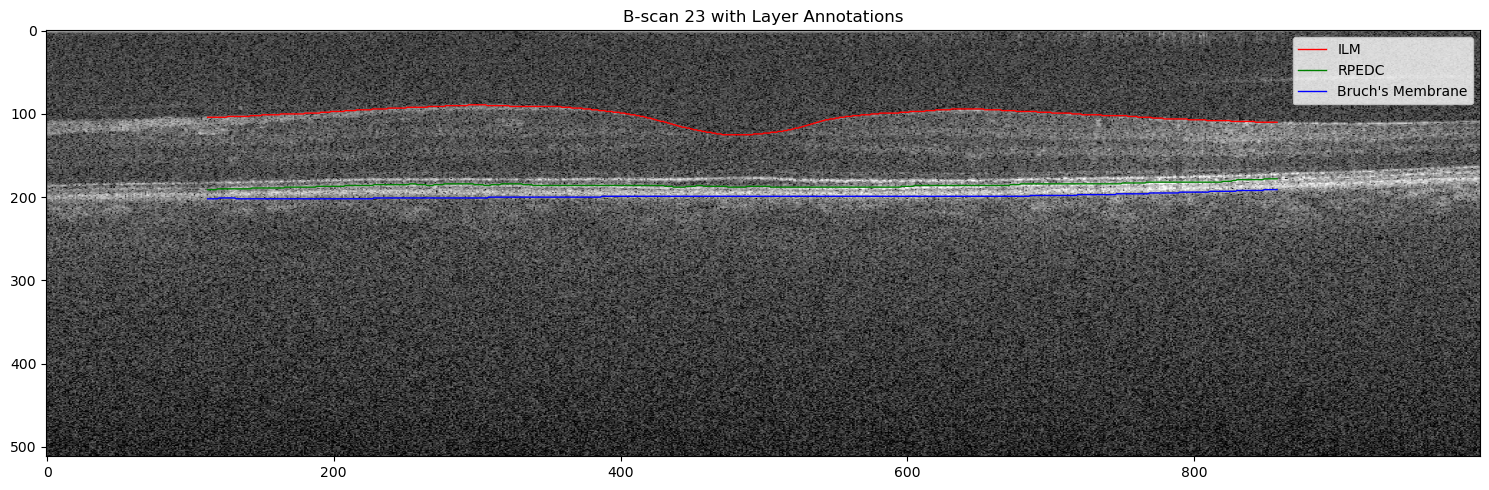

In [9]:

# Visualize a few examples
example_indices = [ 23]
for idx in example_indices:
    plot_bscan_with_layers(idx)

# Image and Layer Map Preprocessing

Now we'll implement preprocessing for both images and layer maps to prepare the data for the Swin-Tiny segmentation model.

In [10]:
def preprocess_images(images_data, crop_height=300):
    """
    Preprocess OCT B-scan images:
    1. Crop to focus on retinal area (0 to crop_height)
    2. Normalize pixel values to [0, 1] using min-max scaling
    
    Args:
        images_data: Input images array
        crop_height: Height to crop the images to (default: 300)
    
    Returns:
        Preprocessed images as tf.float32 tensor
    """
    # Crop images to focus on retinal area (remove noisy bottom regions)
    cropped_images = images_data[:, :crop_height, :]  # Shape: (N, 300, 1000)
    
    # Normalize pixel values to [0, 1] using min-max scaling
    # We'll do this per image to handle varying contrast
    normalized_images = []
    
    for img in cropped_images:
        img_min = np.min(img)
        img_max = np.max(img)
        # Avoid division by zero
        if img_max > img_min:
            normalized_img = (img - img_min) / (img_max - img_min)
        else:
            normalized_img = img - img_min  # Will be all zeros if constant image
        normalized_images.append(normalized_img)
    
    # Convert to numpy array and then to TensorFlow tensor
    normalized_images = np.array(normalized_images, dtype=np.float32)
    
    return tf.convert_to_tensor(normalized_images, dtype=tf.float32)

In [11]:
def preprocess_layer_maps(layer_maps_data, crop_height=300):
    """
    Preprocess layer maps for segmentation:
    1. Extract only ILM (layer 0) and BM (layer 1), removing RPE (layer 2)
    2. Handle NaN values by interpolation or masking
    3. Adjust layer heights according to the cropped image size
    4. Reshape to (N, 1000, 2) format for coordinate prediction
    
    Args:
        layer_maps_data: Input layer maps array (N, 1000, 3)
        crop_height: Height that images were cropped to
    
    Returns:
        Preprocessed layer maps as tf.float32 tensor (N, 1000, 2)
    """
    # Extract only ILM (index 0) and BM (index 1), exclude RPE (index 2)
    ilm_bm_layers = layer_maps_data[:, :, :2].copy()  # Shape: (N, 1000, 2)
    
    # Improved NaN handling: interpolate only between valid values, keep regions with all NaN as NaN
    for i in range(ilm_bm_layers.shape[0]):  # For each sample
        for j in range(ilm_bm_layers.shape[2]):  # For each layer (ILM, BM)
            layer_data = ilm_bm_layers[i, :, j]
            valid_mask = ~np.isnan(layer_data)
            if np.any(valid_mask):
                valid_indices = np.where(valid_mask)[0]
                valid_values = layer_data[valid_mask]
                all_indices = np.arange(len(layer_data))
                interpolated = layer_data.copy()
                if len(valid_indices) > 1:
                    # Interpolate only within valid range
                    interp_range = (valid_indices[0], valid_indices[-1])
                    interp_indices = np.arange(interp_range[0], interp_range[1]+1)
                    interp_values = np.interp(interp_indices, valid_indices, valid_values)
                    interpolated[interp_range[0]:interp_range[1]+1] = interp_values
                # Set regions outside valid range to NaN
                interpolated[:valid_indices[0]] = np.nan
                interpolated[valid_indices[-1]+1:] = np.nan
                ilm_bm_layers[i, :, j] = interpolated
            else:
                # If no valid values, keep as NaN
                ilm_bm_layers[i, :, j] = np.nan
    # Clip layer heights to be within the cropped image bounds
    # Any layer heights >= crop_height should be clipped
    clipped_layers = np.clip(ilm_bm_layers, 0, crop_height - 1)
    
    # Normalize layer heights to [0, 1] range based on crop_height
    normalized_layers = clipped_layers / (crop_height - 1)
    
    # Convert to TensorFlow tensor
    return tf.convert_to_tensor(normalized_layers, dtype=tf.float32)

In [12]:
# Load and preprocess the first 1000 images for test run
print("Loading and preprocessing data...")

# Use first 1000 images for test run
num_samples = 1000
raw_images = images[:num_samples]
raw_layers = layers[:num_samples]

print(f"Original image shape: {raw_images.shape}")
print(f"Original layer shape: {raw_layers.shape}")

# Preprocess images and layer maps
processed_images = preprocess_images(raw_images, crop_height=300)
processed_layers = preprocess_layer_maps(raw_layers, crop_height=300)

print(f"Processed image shape: {processed_images.shape}")
print(f"Processed layer shape: {processed_layers.shape}")
print(f"Image dtype: {processed_images.dtype}")
print(f"Layer dtype: {processed_layers.dtype}")

# Check value ranges
print(f"\nImage value range: [{tf.reduce_min(processed_images):.3f}, {tf.reduce_max(processed_images):.3f}]")
print(f"Layer value range: [{tf.reduce_min(processed_layers):.3f}, {tf.reduce_max(processed_layers):.3f}]")

Loading and preprocessing data...
Original image shape: (1000, 512, 1000)
Original layer shape: (1000, 1000, 3)
Original image shape: (1000, 512, 1000)
Original layer shape: (1000, 1000, 3)
Processed image shape: (1000, 300, 1000)
Processed layer shape: (1000, 1000, 2)
Image dtype: <dtype: 'float32'>
Layer dtype: <dtype: 'float32'>

Image value range: [0.000, 1.000]
Layer value range: [nan, nan]
Processed image shape: (1000, 300, 1000)
Processed layer shape: (1000, 1000, 2)
Image dtype: <dtype: 'float32'>
Layer dtype: <dtype: 'float32'>

Image value range: [0.000, 1.000]
Layer value range: [nan, nan]


I0000 00:00:1752602900.517555   26049 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 2553 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1650 Ti, pci bus id: 0000:01:00.0, compute capability: 7.5
2025-07-15 14:08:20.518583: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1200000000 exceeds 10% of free system memory.


In [13]:
# Debug the layer data issue
print("Debugging layer data...")
print(f"Raw layer shape: {raw_layers.shape}")
print(f"Raw layer dtype: {raw_layers.dtype}")
print(f"Raw layer min: {np.nanmin(raw_layers)}")
print(f"Raw layer max: {np.nanmax(raw_layers)}")
print(f"NaN count in raw layers: {np.isnan(raw_layers).sum()}")

# Check a specific sample
sample_idx = 0
print(f"\nSample {sample_idx} layer data:")
print(f"Shape: {raw_layers[sample_idx].shape}")
print(f"ILM range: {np.nanmin(raw_layers[sample_idx, :, 0]):.1f} - {np.nanmax(raw_layers[sample_idx, :, 0]):.1f}")
print(f"BM range: {np.nanmin(raw_layers[sample_idx, :, 1]):.1f} - {np.nanmax(raw_layers[sample_idx, :, 1]):.1f}")
print(f"RPE range: {np.nanmin(raw_layers[sample_idx, :, 2]):.1f} - {np.nanmax(raw_layers[sample_idx, :, 2]):.1f}")

# Check for negative values or values > 512
print(f"\nValues < 0: {np.sum(raw_layers < 0)}")
print(f"Values > 512: {np.sum(raw_layers > 512)}")
print(f"Values == NaN: {np.sum(np.isnan(raw_layers))}")

Debugging layer data...
Raw layer shape: (1000, 1000, 3)
Raw layer dtype: float32
Raw layer min: 24.0
Raw layer max: 352.0
NaN count in raw layers: 901830

Sample 0 layer data:
Shape: (1000, 3)
ILM range: 113.0 - 124.0
BM range: 193.0 - 206.0
RPE range: 202.0 - 216.0

Values < 0: 0
Values > 512: 0
Values == NaN: 901830


In [14]:
# Reprocess with fixed layer preprocessing function
print("Reprocessing data with NaN handling...")

# Preprocess images and layer maps with fixed function
processed_images = preprocess_images(raw_images, crop_height=300)
processed_layers = preprocess_layer_maps(raw_layers, crop_height=300)

print(f"Processed image shape: {processed_images.shape}")
print(f"Processed layer shape: {processed_layers.shape}")
print(f"Image dtype: {processed_images.dtype}")
print(f"Layer dtype: {processed_layers.dtype}")

# Check value ranges
print(f"\nImage value range: [{tf.reduce_min(processed_images):.3f}, {tf.reduce_max(processed_images):.3f}]")
print(f"Layer value range: [{tf.reduce_min(processed_layers):.3f}, {tf.reduce_max(processed_layers):.3f}]")

# Check for NaN values
print(f"\nNaN check:")
print(f"NaN in processed images: {tf.reduce_any(tf.math.is_nan(processed_images))}")
print(f"NaN in processed layers: {tf.reduce_any(tf.math.is_nan(processed_layers))}")

Reprocessing data with NaN handling...
Processed image shape: (1000, 300, 1000)
Processed layer shape: (1000, 1000, 2)
Image dtype: <dtype: 'float32'>
Layer dtype: <dtype: 'float32'>

Image value range: [0.000, 1.000]
Layer value range: [nan, nan]

NaN check:
NaN in processed images: False
NaN in processed layers: True
Processed image shape: (1000, 300, 1000)
Processed layer shape: (1000, 1000, 2)
Image dtype: <dtype: 'float32'>
Layer dtype: <dtype: 'float32'>

Image value range: [0.000, 1.000]
Layer value range: [nan, nan]

NaN check:
NaN in processed images: False
NaN in processed layers: True


2025-07-15 14:08:32.372019: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1200000000 exceeds 10% of free system memory.


In [15]:
# Split data into train/test (900/100)
from sklearn.model_selection import train_test_split

# Convert TensorFlow tensors to numpy arrays for sklearn compatibility
images_np = processed_images.numpy()
layers_np = processed_layers.numpy()

# Split data: 900 for training, 100 for testing
train_images_np, test_images_np, train_layers_np, test_layers_np = train_test_split(
    images_np, 
    layers_np, 
    test_size=100, 
    train_size=900, 
    random_state=42
)

# Convert back to TensorFlow tensors
train_images = tf.convert_to_tensor(train_images_np, dtype=tf.float32)
test_images = tf.convert_to_tensor(test_images_np, dtype=tf.float32)
train_layers = tf.convert_to_tensor(train_layers_np, dtype=tf.float32)
test_layers = tf.convert_to_tensor(test_layers_np, dtype=tf.float32)

print(f"Training set - Images: {train_images.shape}, Layers: {train_layers.shape}")
print(f"Test set - Images: {test_images.shape}, Layers: {test_layers.shape}")

# Create TensorFlow datasets for efficient training
train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_layers))
test_dataset = tf.data.Dataset.from_tensor_slices((test_images, test_layers))

print(f"\nDatasets created successfully!")
print(f"Train dataset: {train_dataset}")
print(f"Test dataset: {test_dataset}")

2025-07-15 14:08:48.966209: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1200000000 exceeds 10% of free system memory.
2025-07-15 14:08:50.044859: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1080000000 exceeds 10% of free system memory.
2025-07-15 14:08:50.725691: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1080000000 exceeds 10% of free system memory.
2025-07-15 14:08:50.044859: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1080000000 exceeds 10% of free system memory.
2025-07-15 14:08:50.725691: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1080000000 exceeds 10% of free system memory.


Training set - Images: (900, 300, 1000), Layers: (900, 1000, 2)
Test set - Images: (100, 300, 1000), Layers: (100, 1000, 2)

Datasets created successfully!
Train dataset: <_TensorSliceDataset element_spec=(TensorSpec(shape=(300, 1000), dtype=tf.float32, name=None), TensorSpec(shape=(1000, 2), dtype=tf.float32, name=None))>
Test dataset: <_TensorSliceDataset element_spec=(TensorSpec(shape=(300, 1000), dtype=tf.float32, name=None), TensorSpec(shape=(1000, 2), dtype=tf.float32, name=None))>

Datasets created successfully!
Train dataset: <_TensorSliceDataset element_spec=(TensorSpec(shape=(300, 1000), dtype=tf.float32, name=None), TensorSpec(shape=(1000, 2), dtype=tf.float32, name=None))>
Test dataset: <_TensorSliceDataset element_spec=(TensorSpec(shape=(300, 1000), dtype=tf.float32, name=None), TensorSpec(shape=(1000, 2), dtype=tf.float32, name=None))>


In [16]:
def plot_preprocessed_bscan_with_layers(images_tensor, layers_tensor, idx, crop_height=300):
    """Plot preprocessed B-scan with layer annotations"""
    # Convert tensors to numpy for plotting
    image = images_tensor[idx].numpy()
    layers_data = layers_tensor[idx].numpy()  # Shape: (1000, 2)
    
    # Create figure
    plt.figure(figsize=(15, 6))
    
    # Plot preprocessed B-scan
    plt.imshow(image, cmap='gray', aspect='auto', extent=[0, 1000, crop_height, 0])
    
    # Plot layer annotations (convert normalized back to pixel coordinates)
    x_coords = np.arange(1000)
    ilm_heights = layers_data[:, 0] * (crop_height - 1)  # ILM layer
    bm_heights = layers_data[:, 1] * (crop_height - 1)   # BM layer
    
    plt.plot(x_coords, ilm_heights, color='red', label='ILM', linewidth=2)
    plt.plot(x_coords, bm_heights, color='green', label='BM', linewidth=2)
    
    plt.title(f'Preprocessed B-scan {idx} (Cropped to {crop_height}px) with Layer Annotations')
    plt.xlabel('Width (pixels)')
    plt.ylabel('Height (pixels)')
    plt.legend(loc='upper right')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    # Print some statistics
    print(f"Image shape: {image.shape}")
    print(f"Image value range: [{image.min():.3f}, {image.max():.3f}]")
    print(f"ILM heights range: [{ilm_heights.min():.1f}, {ilm_heights.max():.1f}] pixels")
    print(f"BM heights range: [{bm_heights.min():.1f}, {bm_heights.max():.1f}] pixels")

In [ ]:
'''
# Visualize a few preprocessed examples from training set
print("=== TRAINING SET EXAMPLES ===")
train_example_indices = [0, 50, 100]
for idx in train_example_indices:
    print(f"\nTraining sample {idx}:")
    plot_preprocessed_bscan_with_layers(train_images, train_layers, idx)
    print("-" * 50)
    '''

In [ ]:
''' 
# Visualize a few preprocessed examples from test set
print("=== TEST SET EXAMPLES ===")
test_example_indices = [0,1 , 25, 50]
for idx in test_example_indices:
    print(f"\nTest sample {idx}:")
    plot_preprocessed_bscan_with_layers(test_images, test_layers, idx)
    print("-" * 50)
'''

In [21]:
# Data summary and validation
print("=== DATA PREPROCESSING SUMMARY ===")
print(f"Original data shape: Images {images.shape}, Layers {layers.shape}")
print(f"Using first {num_samples} samples for test run")
print(f"Image cropping: From {images.shape[1]} to 300 pixels height")
print(f"Layer processing: Using only ILM and BM (excluding RPE)")
print(f"Normalization: Images [0,1], Layers [0,1]")
print(f"Data split: 900 training, 100 test samples")

print(f"\n=== FINAL DATASET SHAPES ===")
print(f"Training: Images {train_images.shape}, Layers {train_layers.shape}")
print(f"Test: Images {test_images.shape}, Layers {test_layers.shape}")

'''
print(f"\n=== DATA VALIDATION ===")
print(f"No NaN in train images: {not tf.reduce_any(tf.math.is_nan(train_images))}")
print(f"No NaN in train layers: {not tf.reduce_any(tf.math.is_nan(train_layers))}")
print(f"No NaN in test images: {not tf.reduce_any(tf.math.is_nan(test_images))}")
print(f"No NaN in test layers: {not tf.reduce_any(tf.math.is_nan(test_layers))}")

'''
print(f"\nTrain images range: [{tf.reduce_min(train_images):.3f}, {tf.reduce_max(train_images):.3f}]")
print(f"Train layers range: [{tf.reduce_min(train_layers):.3f}, {tf.reduce_max(train_layers):.3f}]")

print(f"\n✅ Data preprocessing completed successfully!")
print(f"Ready for Swin-Tiny model training!")

=== DATA PREPROCESSING SUMMARY ===
Original data shape: Images (5088, 512, 1000), Layers (5088, 1000, 3)
Using first 1000 samples for test run
Image cropping: From 512 to 300 pixels height
Layer processing: Using only ILM and BM (excluding RPE)
Normalization: Images [0,1], Layers [0,1]
Data split: 900 training, 100 test samples

=== FINAL DATASET SHAPES ===
Training: Images (900, 300, 1000), Layers (900, 1000, 2)
Test: Images (100, 300, 1000), Layers (100, 1000, 2)

Train images range: [0.000, 1.000]
Train layers range: [nan, nan]

✅ Data preprocessing completed successfully!
Ready for Swin-Tiny model training!


In [28]:

import tensorflow as tf
from transformers import TFSwinModel
import datetime
print(tf.__version__)


2.18.1


In [29]:
# prepare data pipeline

In [34]:
# Resize images to compatible shape (256x1024) for Swin-Tiny
def resize_data(images):
    images = tf.image.resize(images, [256, 1024], method='bilinear')
    images = tf.expand_dims(images, axis=-1) # Add channel dimension
    return images

In [35]:
train_images = resize_data(train_images)
test_images = resize_data(test_images)

2025-07-15 14:59:25.997377: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:497] Allocator (GPU_0_bfc) ran out of memory trying to allocate 900.00MiB (rounded to 943718400)requested by op ResizeBilinear
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocation summary follows.
Current allocation summary follows.
2025-07-15 14:59:25.997447: I external/local_xla/xla/tsl/framework/bfc_allocator.cc:1053] BFCAllocator dump for GPU_0_bfc
2025-07-15 14:59:25.997473: I external/local_xla/xla/tsl/framework/bfc_allocator.cc:1060] Bin (256): 	Total Chunks: 5, Chunks in use: 5. 1.2KiB allocated for chunks. 1.2KiB in use in bin. 33B client-requested in use in bin.
2025-07-15 14:59:25.997491: I external/local_xla/xla/tsl/framework/bfc_allocator.cc:1060] Bin (512): 	Total Chunks: 0, Chunks in use: 0. 0B allocated for chunks. 0B in use in bin. 0B client-requested in use in bin.
2025-07-15 14:59:25.99

ResourceExhaustedError: {{function_node __wrapped__ResizeBilinear_device_/job:localhost/replica:0/task:0/device:GPU:0}} OOM when allocating tensor with shape[900,256,1024,1] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc [Op:ResizeBilinear] name: 

In [ ]:
# Convert to TensorFlow dataset
train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_layers)).batch(2).prefetch(tf.data.AUTOTUNE)
test_dataset = tf.data.Dataset.from_tensor_slices((test_images, test_layers)).batch(2).prefetch(tf.data.AUTOTUNE)

In [ ]:
# Load preprocessed data (assuming tensors are already normalized)
with h5py.File('preprocessed_data.h5', 'r') as f:
train_images = f['train_images'][:] # (900, 300, 1000)
train_layers = f['train_layers'][:] # (900, 1000, 2)
test_images = f['test_images'][:] # (100, 300, 1000)
test_layers = f['test_layers'][:] # (100, 1000, 2)

# Resize images to compatible shape (256x1024) for Swin-Tiny
def resize_data(images):
images = tf.image.resize(images, [256, 1024], method='bilinear')
images = tf.expand_dims(images, axis=-1) # Add channel dimension
return images

train_images = resize_data(train_images)
test_images = resize_data(test_images)

# Convert to TensorFlow dataset
train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_layers)).batch(2).prefetch(tf.data.AUTOTUNE)
test_dataset = tf.data.Dataset.from_tensor_slices((test_images, test_layers)).batch(2).prefetch(tf.data.AUTOTUNE)

# Load Swin-Tiny base model
base_model = TFSwinModel.from_pretrained("microsoft/swin-tiny-patch4-window7-224")

# Create regression head
input_layer = tf.keras.layers.Input(shape=(256, 1024, 1))
x = base_model(input_layer).last_hidden_state # Get feature maps
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(1000 * 2, activation='linear')(x) # Predict 1000 points for ILM and BM
output = tf.keras.layers.Reshape((1000, 2))(x)

# Build and compile model
model = tf.keras.Model(inputs=input_layer, outputs=output)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
loss=tf.keras.losses.MeanSquaredError())

# Enable mixed precision
tf.keras.mixed_precision.set_global_policy('mixed_float16')

# TensorBoard callback
log_dir = "logs/fit/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

# Train model
model.fit(train_dataset, validation_data=test_dataset, epochs=10, callbacks=[tensorboard_callback])

# Evaluate model
test_loss = model.evaluate(test_dataset)
print(f"Test MSE: {test_loss}")

# Visualize predictions for TensorBoard
def log_predictions(images, labels, predictions):
for i in range(min(5, len(images))): # Log first 5 samples
pred_ilm, pred_bm = predictions[i][:, 0], predictions[i][:, 1]
gt_ilm, gt_bm = labels[i][:, 0], labels[i][:, 1]
fig = tf.keras.preprocessing.image.array_to_img(images[i])
with tf.summary.create_file_writer(log_dir).as_default():
tf.summary.image("Sample_" + str(i), [fig], step=0)
tf.summary.text("GT_ILM_" + str(i), str(gt_ilm.numpy()), step=0)
tf.summary.text("GT_BM_" + str(i), str(gt_bm.numpy()), step=0)
tf.summary.text("Pred_ILM_" + str(i), str(pred_ilm.numpy()), step=0)
tf.summary.text("Pred_BM_" + str(i), str(pred_bm.numpy()), step=0)

# Generate predictions and log
test_images_batch, test_labels_batch = next(iter(test_dataset))
predictions = model.predict(test_images_batch)
log_predictions(test_images_batch, test_labels_batch, predictions)